In [12]:
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [203]:
import altair as alt
import json
import os
import pandas as pd
from pandas.io.json import json_normalize

# Get Data

## File Paths

In [6]:
HOME_DIR = os.getcwd().split('/notebooks')[0]
DATA_DIR = os.path.join(HOME_DIR, 'data')

fe_toronto_json_path = os.path.join(DATA_DIR, 'city/toronto/festivals-and-events_toronto.json')

## Festival & Events Toronto Data

### Get data

In [266]:
with open(fe_toronto_json_path, 'r') as read_file:
    fe_toronto_json = json.load(read_file)

fe_toronto_json = [calender_event_object['calEvent'] for calender_event_object in fe_toronto_json]
fe_toronto = json_normalize(fe_toronto_json)

### Format data

In [267]:
# convert time related columns to datetime
time_columns = [ 
    col_name 
    for col_name in fe_toronto.columns.values 
    if (('Date' in col_name) or ('Time' in col_name)) and (col_name != 'weeklyDates')
]

for col_name in time_columns:
    fe_toronto[col_name] = pd.to_datetime(fe_toronto[col_name])
    

# drop homepageOrder columns
homePageOrder_colnames = [c for c in fe_toronto.columns if 'homePageOrder' in c]
for col_name in homePageOrder_colnames:
    del fe_toronto[col_name]

## Get Event Date Ranges DataFrame

In [201]:
# get naive list of date ranges on which each event will run
event_date_ranges_list = [pd.date_range(start,end) 
                          for start, end in zip(fe_toronto['startDate'],fe_toronto['endDate'])
                         ]

# create list of dataframe for each event to concatnate later
event_date_ranges_df_list = []
for event_number, date_range in enumerate(event_date_ranges_list):
    
    # replace naive date range if actual date ranges are given
    event_weekly_dates = fe_toronto['weeklyDates'][event_number]
    if type(event_weekly_dates) == list:
        event_weekly_dates = pd.to_datetime([record['startTime'] for record in event_weekly_dates])
        date_range = event_weekly_dates
    
    event_date_ranges_df_list += [
        pd.DataFrame({
            'event_number': [event_number for d in range(date_range.size)] , 
            'date': date_range
        })
    ]
    
event_date_ranges = pd.concat(event_date_ranges_df_list)

# add column for all dates
dates = pd.date_range(fe_toronto['startDate'].min(),fe_toronto['endDate'].max())
dates = pd.DataFrame({'date': dates})

event_date_ranges = pd.merge(event_date_ranges, dates, how='right', on='date')

## Get Event Categories Dataset

In [287]:
# create event_categories dataset after spliting event category strings
event_categories = (
    pd.DataFrame(
        fe_toronto['categoryString']
        .str
        .split(',')
        .tolist(),
        index=pd.Series(range(fe_toronto.shape[0]), name='event_number')
    )
    .stack()
    .reset_index([0, 'event_number'])
    .rename(columns={0:'category'})
)

### Format Data

In [288]:
# add relevant organization information
organization_information = fe_toronto[['orgName', 'orgType']].copy()
organization_information['event_number'] = range(fe_toronto.shape[0])

event_categories = pd.merge(event_categories, organization_information, on='event_number')

# add relevant date column 
event_categories = pd.merge(event_categories, event_date_ranges, on='event_number')

# Data Exploration

## Time

### Check if all event records have start & end dates

In [8]:
fe_toronto.shape == fe_toronto.dropna(subset=['startDate', 'endDate']).shape

True

### Explore range & descriptive statistics of events w.r.t time

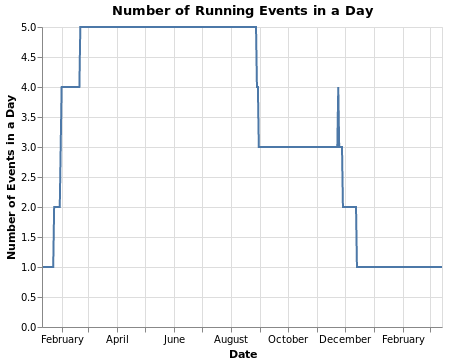

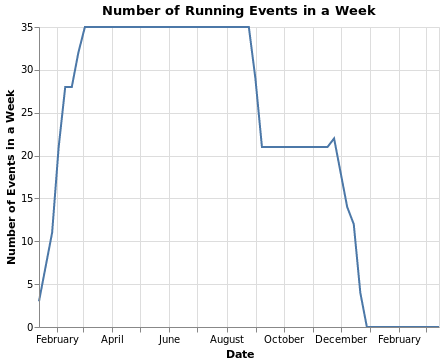

In [206]:
# Plot number of running events in a day over time
(alt
 .Chart(event_date_ranges)
 .mark_line()
 .encode(
     x=alt.X('date', title='Date'),
     y=alt.Y('count(date)', title='Number of Events in a Day')
 )
 .properties(
     title='Number of Running Events in a Day'
 )
)

# Plot number of running events in a week over time
(alt
 .Chart(
     event_date_ranges
     .groupby(pd.Grouper(key='date', freq='W'))
     .count()
     .rename(columns={'event_number': 'event_counts'})
     .reset_index()
 )
 .mark_line()
 .encode(
     x=alt.X('date', title='Date'),
     y=alt.Y('event_counts', title='Number of Events in a Week')
 )
 .properties(
     title='Number of Running Events in a Week'
 )
)

## Event Categories

### Check if all records have a categoryString

In [303]:
fe_toronto.shape == fe_toronto.dropna(subset=['categoryString']).shape

True

### Explore descriptive statistics of the categories w.r.t time

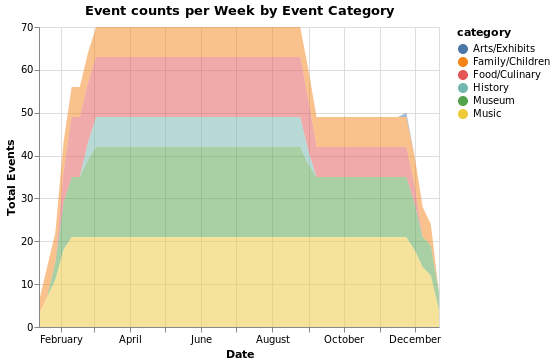

In [340]:
(alt
 .Chart(
     event_categories
     .groupby([pd.Grouper(key='date', freq='W'),'category'])['event_number']
     .count()
     .reset_index()
     .rename(columns={'event_number': 'event_counts'})
 )
 .mark_area(fillOpacity=0.5)
 .encode(
     x=alt.X('date', title='Date'),
     y=alt.Y('event_counts', title='Total Events'),
     color='category'
 )
 .properties(
     title='Event counts per Week by Event Category'
 )
)

## Event Description

### Check if all records have Descriptions

In [213]:
fe_toronto.shape == fe_toronto.dropna(subset=['description']).shape

True

In [215]:
fe_toronto['description'].values

array(['Learn about getting the most out of your fruits and vegetables with food preservation techniques.',
       'This annual juried show features the best recent works from the COAA membership, widely dispersed and diverse, embracing all media and all levels of artistic development.',
       'The LLSC (Leukemia &amp; Lymphoma Society of Canada) Next Gen 2019 Yoga Marathon is back for a second year. This event will help raise meaningful FUNds for the LLSC to help cure leukemia, lymphoma, Hodgkin&#8217;s disease and myeloma. A powerful step towards improving the quality of life for patients and their families.&#10;&#10;Perfect for wellness lovers, yogi fanatics, daredevils and everything in between, this event is a great way to challenge yourself and get sweaty this summer. There will be delicious and hydrating post-class patio drinks and networking opportunities with like-minded, wellness-focused, passionate and welcoming individuals.',
       "Who we are, why we create, and how we r

## Admin Information

### Overview

In [220]:
admin_col_names = [col_name 
                   for col_name in fe_toronto.columns
                   if 'admin' in col_name
                  ]

fe_toronto[admin_col_names]

,admin.updateTimestamp,admin.newsletterCategory,admin.includeInNewsletter,admin.newsletterSubcategory,admin.featuredEvent,admin.approvedTimestamp,admin.subsetCalendar,admin.approvedBy,admin.updatedBy,admin.reviewerComments,admin.includeInMainCalendar,admin.postedTimestamp,admin.rejectedTimestamp,admin.rejectReason,admin.rejectedBy
0,2019-02-08 14:27:35.359000+00:00,[],False,[],false,2019-02-08 14:27:35.359000+00:00,[{'value': '4 Waste Reduction'}],sfernan5,sfernan5,NaN,NaN,NaT,NaT,NaN,NaN
1,2019-01-02 18:43:18.511000+00:00,[],False,[],False,2018-10-25 14:56:04.356000+00:00,[{'value': '1 HAC Exhibits Events'}],cpatter,msilver2,NF 10/23/18,True,NaT,NaT,NaN,NaN
2,2019-07-09 18:29:07.063000+00:00,[],False,[],false,2019-07-09 18:29:07.064000+00:00,[],ksonder,ksonder,KS 7/9/2019,NaN,NaT,NaT,NaN,NaN
3,2018-10-25 14:54:13.183000+00:00,[],False,[],False,2018-10-25 14:54:13.183000+00:00,[{'value': '1 HAC Exhibits Events'}],cpatter,cpatter,NF 10/23/18,True,NaT,NaT,NaN,NaN
4,2018-10-25 14:51:50.801000+00:00,[],False,[],False,2018-10-25 14:51:27.462000+00:00,[{'value': '1 HAC Exhibits Events'}],cpatter,cpatter,NF 10/23/18&#10;CP 10/25/2018,True,NaT,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,2019-07-16 21:44:52.901000+00:00,[],False,[],False,2019-07-16 21:44:52.901000+00:00,[],smotluk,smotluk,SM 07/16/19,NaN,NaT,NaT,NaN,NaN
347,2019-07-16 15:35:29.845000+00:00,[],False,[],False,2019-07-16 15:35:29.845000+00:00,[],smotluk,smotluk,SM 07/16/19,NaN,NaT,NaT,NaN,NaN
348,2019-07-16 16:14:56.822000+00:00,[],False,[],False,2019-07-16 16:14:56.823000+00:00,[],sdair,sdair,SD - July 16 2019,NaN,NaT,NaT,NaN,NaN
349,2019-07-16 18:06:53.174000+00:00,[],False,[],False,2019-07-16 18:06:53.175000+00:00,[],smotluk,smotluk,SM 07/16/19,NaN,NaT,NaT,NaN,NaN


### Rejected applications

In [242]:
fe_toronto['admin.rejectReason'].dropna()
fe_toronto[slice(128,130,None)]

128    Non TPL seminar/workshop MS 020219
129    Non TPL seminar/workshop MS 020119
Name: admin.rejectReason, dtype: object

,orgType,startDate,orgAddress,isCityEvent,terms,endDate,frequency,partnerType,eventWebsite,orgPhone,...,cost.senior,features.Paid Parking,orgTypeOther,eventPhoneExt,admin.postedTimestamp,orgFax,reservation.phoneExt,admin.rejectedTimestamp,admin.rejectReason,admin.rejectedBy
128,Non-Profit,2019-02-01 05:00:00+00:00,3939 Lawrence Ave E,NaN,agree,2019-08-31 04:00:00+00:00,weekly,supportedby,NaN,4166997920,...,NaN,NaN,NaN,402,NaT,NaN,NaN,2019-02-02 20:10:00.167000+00:00,Non TPL seminar/workshop MS 020219,msilver2
129,Non-Profit,2019-02-01 05:00:00+00:00,1765 Weston Road,NaN,agree,2019-08-31 04:00:00+00:00,weekly,supportedby,NaN,4163231429,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,2019-02-01 20:16:30.331000+00:00,Non TPL seminar/workshop MS 020119,msilver2


### Featured Events

In [250]:
fe_toronto[fe_toronto['admin.featuredEvent'] == 'true']

,orgType,startDate,orgAddress,isCityEvent,terms,endDate,frequency,partnerType,eventWebsite,orgPhone,...,cost.senior,features.Paid Parking,orgTypeOther,eventPhoneExt,admin.postedTimestamp,orgFax,reservation.phoneExt,admin.rejectedTimestamp,admin.rejectReason,admin.rejectedBy
101,Public Agency,2019-07-11 04:00:00+00:00,"33 Draper St, Toronto",NaN,agree,2019-07-21 04:00:00+00:00,once,presentedby,http://www.harbourfrontcentre.com/brave/,4168192035,...,NaN,True,NaN,NaN,2019-07-15 14:39:45.175000+00:00,NaN,NaN,NaT,NaN,NaN
177,Non-Profit,2019-07-05 04:00:00+00:00,"1798 Queen St E, Toronto ON M4L 1G8",NaN,agree,2019-07-28 04:00:00+00:00,dates,none,https://beachesjazz.com/,4169047010,...,NaN,True,NaN,NaN,2019-07-02 13:55:12.813000+00:00,NaN,NaN,NaT,NaN,NaN
192,Private/Business,2019-07-21 04:00:00+00:00,84 Rogers Rd,NaN,agree,2019-07-21 04:00:00+00:00,once,producedby,http://www.brazilfest.ca/,4163883052,...,NaN,True,NaN,NaN,2019-07-15 14:49:44.456000+00:00,NaN,NaN,NaT,NaN,NaN
248,Non-Profit,2019-07-20 04:00:00+00:00,"151 Bloor Street West, 12th floor, Toronto, ON...",NaN,agree,2019-07-21 04:00:00+00:00,once,producedby,https://bigonbloorfestival.com/,6478876739,...,NaN,True,NaN,NaN,2019-07-15 14:37:39.081000+00:00,NaN,NaN,NaT,NaN,NaN
273,Other,2019-07-05 04:00:00+00:00,"City Hall, 100 Queen Street West, 8th Floor, ...",True,agree,2019-07-21 04:00:00+00:00,once,producedby,https://www.toronto.ca/summerlicious,4163928123,...,NaN,NaN,Government,NaN,2019-07-02 13:56:41.083000+00:00,NaN,NaN,NaT,NaN,NaN
